In [5]:
import csv
import sys
import os
import math
import random
import numpy as np
import numpy.linalg as npla
import scipy
import sklearn
from scipy import sparse
from scipy import linalg
import scipy.sparse.linalg as spla
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import axes3d
import operator
import statistics
import networkx as nx
import matplotlib.pyplot as plt


In [6]:
import sys
sys.path.append("../Python_code") # go to parent dir
from reddit import *
from canvas_vis import *
from project_data_analysis import *
from generate_proj_to_remove import *

In [10]:
#Run this before anything else!

input_file_proj = "../data/sorted_tile_placements_proj.csv"
input_file_proj_den_freq = "../data/sorted_tile_placements_proj_den_freq.csv"
input_file_proj_den_users = "../data/sorted_tile_placements_proj_den_users.csv"

# input_file_proj_den_freq = "../data/tile_placements_denoised_freq_proj.csv"
# input_file_proj_den_users = "../data/tile_placements_denoised_users_proj.csv"
# js_filename = "../data/atlas.json"
js_filename = "../data/atlas_complete.json"

#Projects to remove 777, 1921 (whole canvas), 1240, 1516 (1 pixel), 1319 (very incomplete)
#1169, 42 (repeated American Flag, 1122), 1066 (repeated blue corner 67), 
#1757 (repeated the far left side 736), 1824 (climber's head, too small)
#320 (repeated kenkistan/rainbow flat 3311)
#351 (repeated erase the place 1297)
#1046, 1073 (repeated channel orange 958)
#998, 1870 (repeated darth plagueis the wise 75)
#1383, 1493, 1823, 1818, 645, 1640 (Very small)
#1811, 1925, 1927, 704, 1085, 1308, 1378, 1412, 1418, 1428, 1455, 1482, 1512, 1548, 1589, 
#1614, 1790, 939, 1263, 1383, 1155, 1524, 129, 1595, 1254, 1528, 1529, 1578, 1616, 1721 (Covered)
# projects_to_remove = {'777', '1921', '1169', '42', '1066', '1757', '1824', '320', '998', '1870', '1811',\
#                      '1925', '1927', '704', '1085', '1308', '1378', '1412', '1418', '1428', '1455', '1482',\
#                       '1512', '1548', '1589', '1614', '1790', '1319', '939', '1263', '1383', '1155', '1761', 
#                      '1524', '351', '129', '1046', '1073', '1595', '1254', '1528', '1529', '1578', '1616',\
#                      '1721'}

#projects_to_remove = get_list_of_removed_proj(output_filename = "../data/proj_to_remove.txt")
# projects_to_remove_ints = {1416,1900,2012,637,2010,1014,1455,1482,61,1913,1820,1493,360,235,645,1797,1990,2016,1418,399,2021,1206,1935,1378,704,1890,1707,1616,1412,23,1715,1658,2004,2025,1512,1790,1811,1383,1649,1348,286,285,1936,1891,1640,49,1763,56,1210,1557,2023,1720,48,1228,1758,1692,1139,1994,1598,1641,581,789,1240,357,1809,2007,1818,1904,1979,2018,347,1908,1122,361,1624,1695,21,123,1308,1824,1970,1548,2,181,46,1319,1981,1976,1039,1659,1940,1516,1823,75,1289,81,1085,1925,236,1849}
# projects_to_remove = set()
# for item in projects_to_remove_ints:
#     projects_to_remove.add(str(item))

locations = store_locations(js_filename)
projects_to_remove = {}

names, descriptions = read_picture_names_and_descriptions_17(js_filename)

In [47]:
from sklearn.cluster import SpectralCoclustering

user_proj_matrix_pixel, users_dict, proj_dict = user_project_matrix_pixel(input_file_proj, projects_to_remove)

users_per_proj_list = users_per_project_list(input_file_proj, projects_to_remove)

In [12]:
# Create a reverse of proj_dict where the keys are the indexes into user_proj_matrix_pixel and the values are
# the project ids
proj_dict_reverse = dict()
for proj_id in proj_dict:
    proj_dict_reverse[ proj_dict[proj_id] ] = proj_id

In [15]:
def compute_edge_weight(val1, val2):
    # Given two values, val1 and val2, where each value represents the number of updates that a single user's 
    # contributed to two different projects, compute the weight of the edge
    return (val1 * val2) / (val1 + val2)

In [16]:
def draw_graph(G, names = dict()):
    '''
        Draw the graph g.
        All edges with a weight < weight_threshold will be colored red and be dashed
        All edges with a weight >= weight_threshold will be colored black and be solid
    '''
    weight_threshold = 0.02
    pos = nx.fruchterman_reingold_layout(G)
#     pos = nx.kamada_kawai_layout(G)
#     pos = nx.spring_layout(G,scale=2)


    nx.draw_networkx_nodes(G,pos,node_color='green',node_size=20)
    lower_weight_edges = list()
    higher_weight_edges = list()
    
    for (node1,node2,data) in G.edges(data=True):
        if data['weight'] < weight_threshold:
            lower_weight_edges.append( (node1, node2) ) 
        else:
            higher_weight_edges.append( (node1, node2) )
    
    # Plot the edges
    nx.draw_networkx_edges(G, pos, width=2, edgelist=lower_weight_edges, edge_color='red', style='dashed')
#     nx.draw_networkx_edges(G, pos, width=2, edgelist=higher_weight_edges, edge_color='black', style='solid')
    nx.draw_networkx_labels(G, pos = pos, labels = names, font_size = 3)

    plt.axis('off')
    plt.figure(None,figsize=(20,20)) 
    plt.savefig("project_relationships_graph.png", bbox_inches='tight', pad_inches=0) 
    plt.show() 

In [48]:
def generate_graph(user_proj_matrix_pixel, threshold):    
    W = np.zeros((user_proj_matrix_pixel.shape[1], user_proj_matrix_pixel.shape[1]))
    
    for u in range(user_proj_matrix_pixel.shape[0]):
        for p1 in user_proj_matrix_pixel.rows[u]:
            for p2 in user_proj_matrix_pixel.rows[u]:
                if p1 < p2:
                    W[p1,p2] +=1
                elif p1 > p2:
                    W[p2,p1] +=1
    
    g = nx.Graph()
    
    for proj in proj_dict_reverse:
        g.add_node(proj)
    
    for p1 in range(user_proj_matrix_pixel.shape[1]):
        for p2 in range(user_proj_matrix_pixel.shape[1]):
            if p1 < p2 and W[p1,p2] > 0:
                p1_id = proj_dict_reverse[p1]
                p2_id = proj_dict_reverse[p2]
                
                if W[p1,p2] > threshold:
                    print("threshold")
                    g.add_edge(p1_id,p2_id, weight=W[p1,p2])
                    
    gccs = sorted((g.subgraph(c) for c in nx.connected_components(g)), key=len, reverse=True)
        
    return gccs[0]

In [23]:
def analyze_project_to_project_weights(g):
    # Print out the max, min, median, mean and standard deviation of all the edge weights of the graph g
    all_weights = list()
    avg = 0

    for (node1,node2,data) in g.edges(data=True):
        all_weights.append(data['weight'])
        avg += data['weight']


    max_weight = max(all_weights)
    min_weight = min(all_weights)
    avg = avg / len(all_weights)
    med = statistics.median(all_weights)
    std_dev = statistics.stdev(all_weights)
    print("MAX:", max_weight)
    print("MIN:",min_weight)
    print("AVG:",avg)
    print("MED:", med)
    print("STD_DEV:", std_dev)
    
analyze_project_to_project_weights(g)

MAX: 10217.556040905432
MIN: 0.5
AVG: 5.7220056374684605
MED: 0.9
STD_DEV: 60.25418450485868


In [51]:
# Normalize edge weights
g = generate_graph(user_proj_matrix_pixel, 1000)
#normalized_g = nx.Graph()
#for (node1,node2,data) in g.edges(data=True):
#    new_weight = data['weight'] / np.sqrt( g.degree(node1, weight = 'weight') * g.degree(node2, weight = 'weight') )
#    normalized_g.add_edge(node1, node2, weight = new_weight)

threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold
threshold


In [52]:
len(g.nodes())

55

In [29]:
# Remove all edges under unnormalized threshold
# This doesnt work for some reason. 
# Copy-paste to use
def remove_edges(g, threshold = 0.001, print_data = True):

    edges_to_remove = list()

    for (node1,node2,data) in g.edges(data=True):
        if data['weight'] <= threshold:
            edges_to_remove.append((node1, node2))

    for (node1, node2) in edges_to_remove:
        g.remove_edge(node1, node2)

    if print_data:
        print(len(edges_to_remove), "edges removed")
        print(len(g.edges),"edges remaining")
        analyze_project_to_project_weights(g)

In [27]:
# Check now whether there are any projects with no edges
# This would mean all of the edge weights must've been under threshold
nodes_to_remove = list(nx.isolates(g))
g.remove_nodes_from(nodes_to_remove)
print(len(nodes_to_remove),"nodes removed")
print(len(g.nodes()),"nodes remaining")

1 nodes removed
1400 nodes remaining


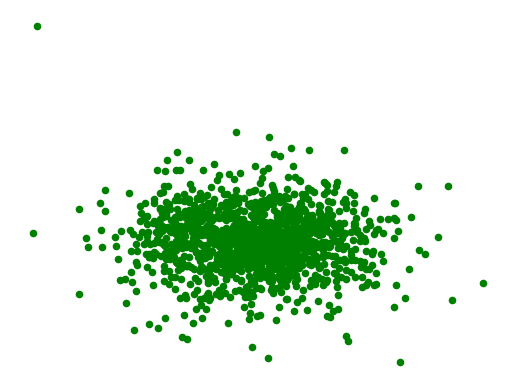

<Figure size 2000x2000 with 0 Axes>

In [41]:
# nx.write_gexf(g, "test_graph.gexf")
draw_graph(g)